In [16]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import gc
import collections
import matplotlib.pyplot as plt
import seaborn as sns

<h2> Set up Custom Gradient Descent </h2>

In [17]:
intmatrix = np.load("./data/movie-matrix.npz")["data"]
#Let us define 512-length vector embeddings for users and items such that we prefer higher inner products
latentdim = 512
np.random.seed(1)
Usr = np.random.normal(loc=0, scale=1, size=(intmatrix.shape[0], latentdim))
Itm = np.random.normal(loc=0, scale=1, size=(latentdim, intmatrix.shape[1]))
#We enforce unit-norm embeddings
Usr = Usr/np.sqrt((Usr**2).sum(axis=1)).reshape(-1,1)
Itm = Itm/np.sqrt((Itm**2).sum(axis=1)).reshape(-1,1)

In [18]:
mean = np.sum(intmatrix, axis=1)/(intmatrix!=0).sum(axis=1)
zmask = intmatrix==0
intmatrix = intmatrix-mean.reshape(-1,1)
intmatrix[zmask]=0

In [19]:
#Define Loss
#We add the inner products of all users-items above user-mean and subtract the inner products of all user-items
#below mean. We must maximize this quantity, and hence minimize its negation
def embed_loss(Usr, Itm, intmatrix, wbl=0):
    mat = np.matmul(Usr, Itm)
    posquant = mat[intmatrix>0].sum()
    negquant = mat[intmatrix<0].sum()
    return negquant-posquant

In [20]:
embed_loss(Usr, Itm, intmatrix)

-5.417413548713141

When defining the gradient at each epoch, we realise that, for our embed_loss function $L$, the user matrix P, and the item matrix Q: <br/>
$\frac{dL}{dP} = D \cdot Q^T$ <br/>
$\frac{dL}{dQ} = P^T \cdot D$ <br/>
where D is a matrix with the same dimensions as intmatrix W, 943x1682, and for $1\leq i \leq 943, 1\leq j \leq 1682,$ <br/> $D_{i,j} = -1$ if $W_{i,j}>0$, $1$ if $W_{i,j}<0$ else $0$. Hence D just represents the sign that the inner product takes inside the embed_loss function. Since we negate the result in embed_loss, we can subtract our gradient, in context of a learning rate, at each epoch. Specifically, for epoch $i$, $1 \leq i \leq n$, we can define $P_{i}$ and $Q_{i}$, with $P_{0}$ and $Q_{0}$ being initialized: <br/>
$P_{i} = U(P_{i-1}-\alpha \cdot \frac{dL_{i-1}}{dP_{i-1}})$ <br/>
$Q_{i} = U(Q_{i-1}-\alpha \cdot \frac{dL_{i-1}}{dQ_{i-1}})$ <br/>
for a learning rate $\alpha$
Here, $U$ is the function that reinforces the unit-norm requirement by normalizing all embeddings. This constraint is enforced to ensure that the model actually learns recommendations, and cannot arbitrarily minimize loss by increasing the magnitude of embedding vectors.

In [21]:
#Make the mask matrix D
D = np.zeros((intmatrix.shape[0], intmatrix.shape[1]))
D[intmatrix>0] = -1
D[intmatrix<0] = 1

In [22]:
def epoch_updater(P, Q, D, alpha):
    gradP = np.matmul(D, Q.T)
    gradQ = np.matmul(P.T, D)
    P, Q = P-alpha*gradP, Q-alpha*gradQ
    unitnorm = (lambda s: s/np.sqrt((s**2).sum(axis=1)).reshape(-1,1))
    return unitnorm(P), unitnorm(Q)

We define a learning rate scheduler with exponential decay, such that at some epoch $i$ with $i \geq 2$ and $\alpha_{i}$ being the initial learning rate, $\alpha_{i} = \alpha_{1} \cdot (0.95)^{\sqrt{i}-1}$

In [23]:
def exp_lr_schedule(epoch, lr1):
    return lr1*((0.95)**(np.sqrt(epoch)-1))

<h2> Perform Gradient Descent to Create Recommendation Matrix </h2>

In [24]:
initlr = 1e-2
numepochs = 100
lossque = collections.deque()
alphaque = collections.deque()
print("Initialization. Loss="+str(embed_loss(Usr, Itm, intmatrix)))
for ep in range(1,numepochs+1):
    alpha = exp_lr_schedule(ep, initlr)
    Usr, Itm = epoch_updater(Usr, Itm, D, alpha)
    lossque.append(embed_loss(Usr, Itm, intmatrix))
    alphaque.append(alpha)
    if (ep%20)==0: print("Checkpoint at Epoch "+str(ep))

Initialization. Loss=-5.417413548713141
Checkpoint at Epoch 20
Checkpoint at Epoch 40
Checkpoint at Epoch 60
Checkpoint at Epoch 80
Checkpoint at Epoch 100


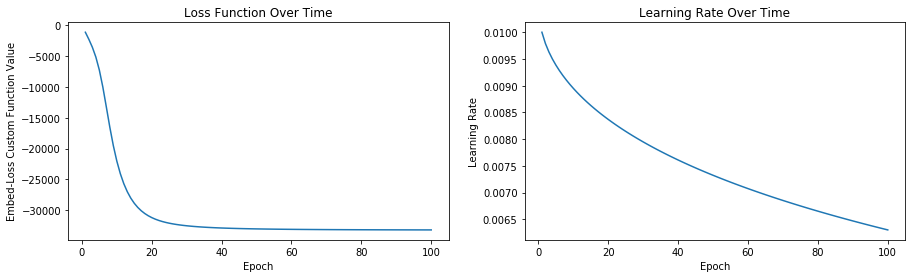

In [26]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
pd.Series(lossque, index=np.arange(numepochs)+1).plot()
plt.xlabel("Epoch")
plt.ylabel("Embed-Loss Custom Function Value")
plt.title("Loss Function Over Time")
plt.subplot(1,2,2)
pd.Series(alphaque, index=np.arange(numepochs)+1).plot()
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Time")
plt.show()

<h2> Evaluating Recommendation Engine Performance </h2>